# Iteration 3<br/>*Custom Transformers with Scikit Learn*

Jupyter Notebook referenced from my website:
[Software Nirvana: Custom Transformers](https://sdiehl28.netlify.com/projects/titanic/titanic03/)

### Goals
1. Perform better Age imputation
2. To avoid data leakage, this requires creating a custom Transform class. Demonstrate this
3. Understand Panda's GroupBy in detail for use in the custom Transform class
4. As part of iterative model development, check if this improves the model's accuracy

### Where We Are
In the second iteration we created a simple model that discarded all non-numeric variables and imputed missing Age values using the mean strategy available from sklearn.preprocessing.Imputer.

### What's Next
Exploratory Data Analysis shows that there is an association between Age and (Pclass, Sex).

Because there is an association, a better imputation of missing Age values is possible.

Scikit Learn does not directly support custom imputation, but we can do so by creating a custom Transfom class.

Imputation is data transformation: missing values are replaced with valid values.  We will create a Transform class which will follow the API convention required by Scikit Learn.

With our custom Transform in place, we will place it in a Pipeline and evaluate model performance using cross validation.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Iteration Setup

In [2]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# Remove PassengerId and all non-numeric fields except Sex
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']
X = X.drop(drop_cols, axis=1)
X.dtypes

Pclass      int64
Sex        object
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [3]:
all_data.shape

(891, 12)

### Exploratory Data Analysis

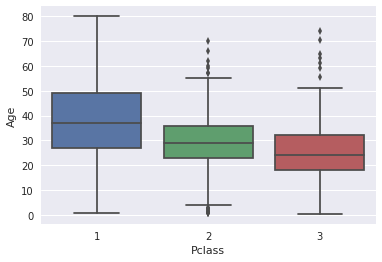

In [4]:
sns.boxplot(x='Pclass', y='Age', data=X)

We see that there is an association between age and passenger class.

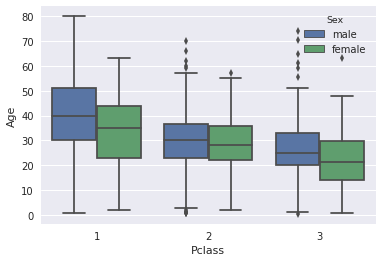

In [5]:
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=X)

We see that for each passenger class, females are younger than males.  One way to impute missing age values then is to use replace the missing age value with the average age in each of the above 6 groups.

### Group By
pd.DataFrame.groupby() serves the same purpose as SQL's "Group By".  An alternative term sometimes used in statistics, is "conditioned on".

In Pandas, DataFrame.groupby() will:
* split the original DataFrame into a collection of DataFrames
* the union of all DataFrames in that collection is the original DataFrame
* each Dataframe in the collection contains values which are identical for those columns being grouped over

An example will make this clearer.

In [6]:
# print datatype returned from groupby operation
by_pclass_sex = X.groupby(['Pclass', 'Sex'])
print(type(by_pclass_sex))

<class 'pandas.core.groupby.DataFrameGroupBy'>


In [7]:
# DataFrameGroupBy is an iterable, what data types does its iterator return?
list(map(type, next(iter(by_pclass_sex))))

[tuple, pandas.core.frame.DataFrame]

In [8]:
# Equivalently
for group_key, group_value in by_pclass_sex:
    print(type(group_key))
    print(type(group_value))
    break

<class 'tuple'>
<class 'pandas.core.frame.DataFrame'>


Let's examine the contents of the DataFrameGroupBy by iterating over it.

In [9]:
# let's look at the keys
for group_key, group_value in by_pclass_sex:
    print(group_key)

(1, 'female')
(1, 'male')
(2, 'female')
(2, 'male')
(3, 'female')
(3, 'male')


There are 6 keys, one for each combination of the values of passenger class and sex.

In [10]:
# let's look at the first 3 records in each value
for group_key, group_value in by_pclass_sex:
    print('Group Key:', group_key, '\nGroup Value:\n', group_value[:3], '\n')

Group Key: (1, 'female') 
Group Value:
     Pclass     Sex   Age  SibSp  Parch     Fare
1        1  female  38.0      1      0  71.2833
3        1  female  35.0      1      0  53.1000
11       1  female  58.0      0      0  26.5500 

Group Key: (1, 'male') 
Group Value:
     Pclass   Sex   Age  SibSp  Parch      Fare
6        1  male  54.0      0      0   51.8625
23       1  male  28.0      0      0   35.5000
27       1  male  19.0      3      2  263.0000 

Group Key: (2, 'female') 
Group Value:
     Pclass     Sex   Age  SibSp  Parch     Fare
9        2  female  14.0      1      0  30.0708
15       2  female  55.0      0      0  16.0000
41       2  female  27.0      1      0  21.0000 

Group Key: (2, 'male') 
Group Value:
     Pclass   Sex   Age  SibSp  Parch  Fare
17       2  male   NaN      0      0  13.0
20       2  male  35.0      0      0  26.0
21       2  male  34.0      0      0  13.0 

Group Key: (3, 'female') 
Group Value:
     Pclass     Sex   Age  SibSp  Parch     Fare
2   

The most common operation to perform on a groupby object is to apply an aggregate operation to each group.  Here are some examples.

In [11]:
# number of records in each group
print(by_pclass_sex.size())

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
dtype: int64


In [12]:
# Groupby values can either be a dataframe or a series
print(type(by_pclass_sex))
print(type(by_pclass_sex['Age']))

<class 'pandas.core.groupby.DataFrameGroupBy'>
<class 'pandas.core.groupby.SeriesGroupBy'>


In [13]:
# average Age in each group
print(by_pclass_sex['Age'].mean())

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64


In [14]:
# alternative using numpy universal function
print(by_pclass_sex['Age'].apply(np.mean))

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64


In [15]:
# examine the return value above
mean_age_by_pclass_sex = by_pclass_sex['Age'].mean()
print(type(mean_age_by_pclass_sex))
print('Index Names:', mean_age_by_pclass_sex.index.names)
print('Value Name:', mean_age_by_pclass_sex.name)

<class 'pandas.core.series.Series'>
Index Names: ['Pclass', 'Sex']
Value Name: Age


In [16]:
# note: pivot_table is very similar to groupby
X.pivot_table(values='Age', index=['Pclass','Sex'], aggfunc='mean')

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

### Avoiding Data Leakage

**Cross Validation the Right Way**  
As discussed in the previous notebook, we cannot use the entire data set in order to impute age. We must perform the imputation on the training data and test how well it works on the test data.

The following will demonstrate imputing missing Age values, based on passenger class and sex, correctly without data leakage.

The Titanic dataset is used for concreteness, but it is not representative of all datasets.  Understanding how to transform data, and use cross validation correctly, is essential to solving real-world problems.

### Create Custom Transformer Class
Python uses "duck typing", so as long as our class defines a fit() and a transform() method, Scikit Learn can use our class as a Transform.  Nevertheless, it is common practice to inherit from TransformerMixin in order to make the code clearer to others.

The fit() method will compute the mean of Age, grouped by pclass and sex, over the *training* data, and save this object for use in the transform method.

The transform() method will use the mean of Age by pclass and sex, as computed on the training data, to replace missing values on both the training and test data sets.

The Transform class will be used as part of a pipeline with cross_val_score().

#### Vectorization Notes
Generally vectorized operations are faster and easier to maintain.  A vectorized option has no explicit for-loop.  The MyTransform class below has no for-loops.

Some operations internally use for-loops, such as apply(), itertuples(), iterrows(), etc.

In [17]:
from sklearn.base import TransformerMixin
class MyTransformer(TransformerMixin): 
    '''Class with fit() and transform() methods'''

    def fit(self, X, y):
        '''
        fit() will compute and save the mean age per (pclass, sex)
        on the training data
        '''
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'Sex'])['Age'].mean()
        
        # return an instance of MyTransformer
        return self
    
    def transform(self, X):
        '''
        transform() is applied to both train and test data
        
        It will replace missing age values by looking up the
        mean age per (pclass,sex)
        '''
        
        # index into multi-indexed Pandas Series using 2-part key
        # Pandas does not allow indexing by DataFrame, so create list of tuples
        # each tuple is (pclass, sex)
        missing_age_idx = X['Age'].isnull()
        df = X.loc[missing_age_idx, ['Pclass', 'Sex']]
        index_tuples = list(df.itertuples(index=False, name=None))
        
        # lookup mean age in DataFrameGroupBy using list of tuples of (pclass, sex)
        imputed_age_values = self.mean_age_by_pclass_sex.loc[index_tuples].values
        
        # replace the missing values with the imputed age values
        X = X.copy()
        X.loc[missing_age_idx, 'Age'] = imputed_age_values

        # drop the sex column as logicstic regression only works with numerics
        # (later we will encode it and use it)
        return X.drop('Sex', axis=1)

In [18]:
# Code is the same as previous iteration *except* use our custom Transformer
# instead of SciKit Learn's Imputer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

my_transformer = MyTransformer()

from sklearn.pipeline import make_pipeline
classifier = make_pipeline(my_transformer, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("../data/iter03.data", scores)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.689 0.711 0.708 0.697 0.764 0.719 0.742 0.64  0.685 0.739]
0.709


### Compare Model with Previous Iteration

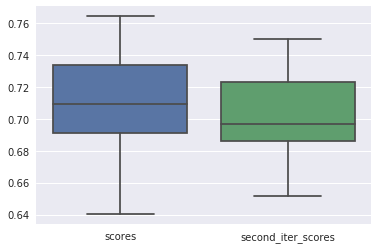

In [19]:
# Read in scores from 2nd iteration
second_iter_scores = np.load('../data/iter02.data.npy')

df = pd.DataFrame(data=list(zip(scores, second_iter_scores)),
                  columns=['scores','second_iter_scores'])
sns.boxplot(data=df)

This is too close to call.  Let's focus in on the paired differences.

In [20]:
# the scores in the ordered list correspond with each other as they were
# perform on the same train/test split
diff_scores = scores - second_iter_scores
print('Score Improvement:',np.round(diff_scores.mean(), 3))
print('Score Diffs:',np.round(sorted(diff_scores),3))

Score Improvement: 0.008
Score Diffs: [-0.011 -0.011  0.     0.011  0.011  0.011  0.011  0.011  0.022  0.022]


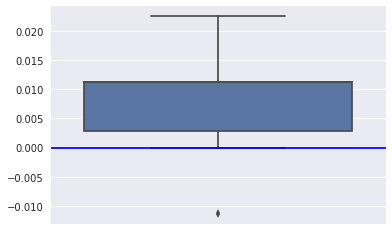

In [21]:
# boxplot the differences and highlight x-axis in blue
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [22]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  7
New Model ties:  1
New Model loses: 2


From the above boxplot and individual comparison of the scores, it appears the new model is slightly better. The change we made was to impute Age by (pclass, sex) using a custom Transform class.

### Model Summary
Model building steps only.

MyTransformer Class is defined above.

In [23]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# Remove PassengerId and all non-numeric fields except Sex
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']
X = X.drop(drop_cols, axis=1)

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# MyTransformer Class defined above
my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

print(np.round(scores,3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

[0.689 0.711 0.708 0.697 0.764 0.719 0.742 0.64  0.685 0.739]
Cross Validated Accuracy: 0.709


In [24]:
# previous model
print(f'Previous Cross Validated Accuracy: {second_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.702


### Notebook Summary

In this iteration we:
* showed how to create a custom Transform object to perform custom Imputation
* examined the GroupBy objects in detail
* performed custom Age Imputation without data leakage
* measured the new model's accuracy and found it was slightly better than the previous iteration (70.9% vs 70.2%).